In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../../src')

wb_dir = '/gpfs/gpfs0/ukb_data/raw_data/white_british'
pgen_train_path = f'{wb_dir}/pgen/train'
pgen_test_path = f'{wb_dir}/pgen/test'
pgen_valid_path = f'{wb_dir}/pgen/valid'
trait_name = 'non_cancers_self_reported_asthma'

In [2]:
import numpy

gwas_logp_path = f'/gpfs/gpfs0/ukb_data/raw_data/runs/run_main/white_british/{trait_name}/chrMAIN.logp.npz'
gwas_data = numpy.load(gwas_logp_path)['chrMAIN']
gwas_indices = numpy.argsort(gwas_data)[::-1]
gwas_indices.shape

(701347,)

In [3]:
import pandas

pvar = pandas.read_csv(f'{pgen_train_path}/les_chrMAIN.pvar', sep='\t')
pvar

/home/a.medvedev/.conda/xgboost-selection/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,#CHROM,POS,ID,REF,ALT
0,1,723307,rs28659788,C,G
1,1,727841,rs116587930,G,A
2,1,729632,rs116720794,C,T
3,1,752721,rs3131972,G,A
4,1,754105,rs12184325,C,T
...,...,...,...,...,...
701342,X,154859910,rs144293808,A,C
701343,X,154865915,rs601290,A,G
701344,X,154899846,rs473491,G,A
701345,X,154900890,rs150522543,C,T


In [7]:
pvar.loc[sorted(gwas_indices[:1000]), ['ID']].to_csv('asthma_temp.snplist', index=False, header=None)


In [16]:
from utils.plink import run_plink19, run_plink


args1 = ['--pfile', pgen_train_path + '/les_chrMAIN', '--extract', 'asthma_temp.snplist', 
         '--make-bed', '--out', 'asthma_temp_ld'] 
run_plink(args1)

In [17]:
args2 = ['--bfile', 'asthma_temp_ld', '--r2', 'inter-chr', 'with-freqs', '--ld-window-r2', '0.0',
        '--ld-snp-list', 'asthma_temp.snplist', '--out', 'asthma_temp.ld']

# args2 = ['--bfile', 'asthma_temp_ld', '--r', 'square', 'bin', 
#         '--ld-snp-list', 'asthma_temp.snplist', '--out', 'asthma_temp.ld']

run_plink19(args2)

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to asthma_temp.ld.log.
Options in effect:
  --bfile asthma_temp_ld
  --ld-snp-list asthma_temp.snplist
  --ld-window-r2 0.0
  --out asthma_temp.ld
  --r2 inter-chr with-freqs

257580 MB RAM detected; reserving 128790 MB for main workspace.
1000 variants loaded from .bim file.
343481 people (157640 males, 185841 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 343481 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.975909.
1000 variants and 343481 people pass filters and QC.
Note: No phenotypes present.
--r2 inter-chr with-freqs to ast

In [4]:
corr_data = pandas.read_table('asthma_temp.ld.ld', sep='\s+')
corr_matrix = numpy.zeros((1000, 1000))
for i, r2 in zip(range(1000*1000), corr_data.R2):
    row, col = i // 1000, i%1000
    corr_matrix[row,  col] = r2
corr_matrix.mean()

0.059208136807418946

/home/a.medvedev/.conda/xgboost-selection/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


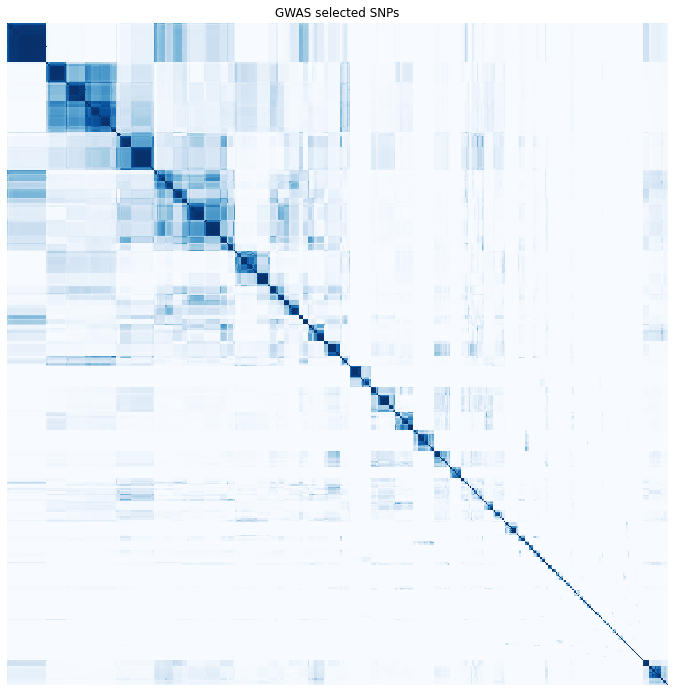

In [6]:
import seaborn



cg = seaborn.clustermap(corr_matrix, dendrogram_ratio=0.01, cmap=seaborn.color_palette("Blues", as_cmap=True))
cg.cax.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_title('GWAS selected SNPs')
# cg.ax_heatmap.set_xlabel('SNP')
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_xticks([])
# for minor ticks
cg.ax_heatmap.set_xticks([], minor=True)
cg.ax_heatmap.set_yticks([])
# for minor ticks
cg.ax_heatmap.set_yticks([], minor=True)

cg.fig.savefig('asthma_GWAS_corr_heatmap_1k_2.png', bbox_inches='tight')
cg

In [8]:
# here we are loading old run
# it is reverse direction 5k window run
from track import Run

snapshot = '911fc91d-5e05-4d7b-91ed-660f035e001e'
run = Run('/beegfs/home/a.medvedev/ukb_ml/runs',
          'white_british_split__non_cancers_self_reported_asthma__v3',
          snapshot=snapshot)
run.chromosomes = ['MAIN']

sel_path = run.results_path('selection_temp.npz')
sel_data = numpy.load(sel_path)['chrMAIN']
sel_indices = numpy.argsort(sel_data)[::-1]
gwas_indices.shape, sel_indices.shape

((701347,), (701347,))

In [9]:
pvar.loc[sorted(sel_indices[:1000]), ['ID']].to_csv('asthma_temp.snplist', index=False, header=None)


In [10]:
from utils.plink import run_plink19, run_plink


args1 = ['--pfile', pgen_train_path + '/les_chrMAIN', '--extract', 'asthma_temp.snplist', 
         '--make-bed', '--out', 'asthma_temp_ld'] 
run_plink(args1)

In [11]:
args2 = ['--bfile', 'asthma_temp_ld', '--r2', 'inter-chr', 'with-freqs', '--ld-window-r2', '0.0',
        '--ld-snp-list', 'asthma_temp.snplist', '--out', 'asthma_temp.ld']

# args2 = ['--bfile', 'asthma_temp_ld', '--r', 'square', 'bin', 
#         '--ld-snp-list', 'asthma_temp.snplist', '--out', 'asthma_temp.ld']

run_plink19(args2)

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to asthma_temp.ld.log.
Options in effect:
  --bfile asthma_temp_ld
  --ld-snp-list asthma_temp.snplist
  --ld-window-r2 0.0
  --out asthma_temp.ld
  --r2 inter-chr with-freqs

257580 MB RAM detected; reserving 128790 MB for main workspace.
1000 variants loaded from .bim file.
343481 people (157640 males, 185841 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 343481 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.98597.
1000 variants and 343481 people pass filters and QC.
Note: No phenotypes present.
--r2 inter-chr with-freqs to asth

In [12]:
corr_data = pandas.read_table('asthma_temp.ld.ld', sep='\s+')
corr_data

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R2
0,1,2338126,rs3795269,0.439447,1,2338126,rs3795269,0.439447,1.000000
1,1,2338126,rs3795269,0.439447,1,2411245,rs41315664,0.007261,0.004569
2,1,2338126,rs3795269,0.439447,1,2504234,rs6671426,0.480670,0.004690
3,1,2338126,rs3795269,0.439447,1,2513216,rs734999,0.478714,0.004467
4,1,2338126,rs3795269,0.439447,1,2922744,rs10797377,0.116984,0.004256
...,...,...,...,...,...,...,...,...,...
999815,23,153828269,rs5986877,0.128344,23,94462197,rs56132106,0.218412,0.000839
999816,23,153828269,rs5986877,0.128344,23,112227602,rs11796036,0.395832,0.002291
999817,23,153828269,rs5986877,0.128344,23,123549896,rs12007060,0.118821,0.000445
999818,23,153828269,rs5986877,0.128344,23,125131855,rs209658,0.178823,0.000967


In [13]:
snps = pandas.read_csv('asthma_temp.snplist', header=None, names=['snp'])
snps

,snp
0,rs3795269
1,rs41315664
2,rs6671426
3,rs734999
4,rs10797377
...,...
995,rs56132106
996,rs11796036
997,rs12007060
998,rs209658


In [14]:
corr_dict = {snp: i for i, snp in enumerate(snps.snp)}
corr_matrix = numpy.zeros((1000, 1000))
for snp1, snp2, r2 in zip(corr_data.SNP_A, corr_data.SNP_B, corr_data.R2):
    row, col = corr_dict[snp1], corr_dict[snp2]
    corr_matrix[row,  col] = r2
corr_matrix.mean()

0.0015551067058289416

/home/a.medvedev/.conda/xgboost-selection/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


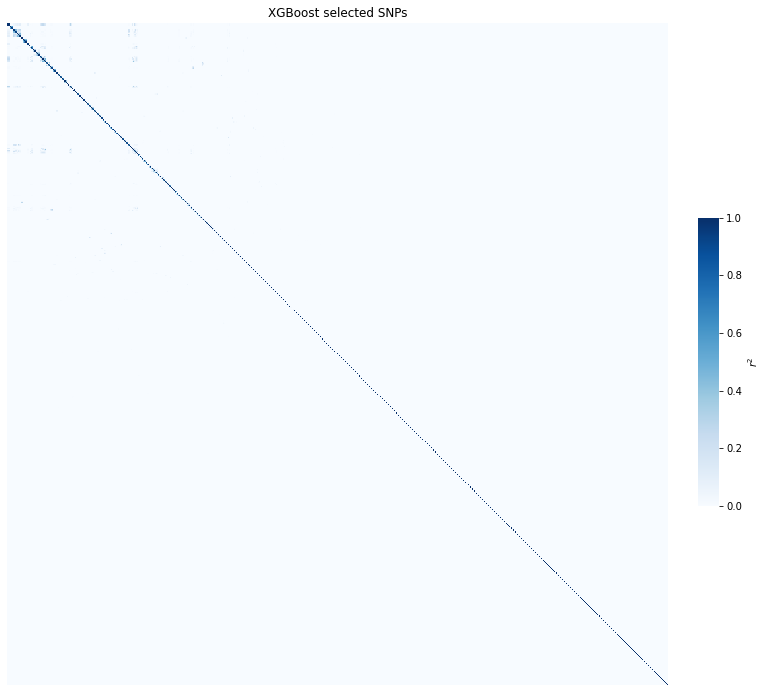

In [15]:
cg = seaborn.clustermap(corr_matrix, cbar_pos=(0.99, .3, .03, .4), cmap=seaborn.color_palette("Blues", as_cmap=True),
                        cbar_kws={'label': '$r^2$'}, dendrogram_ratio=0.01)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_title('XGBoost selected SNPs')
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
# cg.ax_heatmap.set_xlabel('SNP')
cg.ax_heatmap.set_xticks([])
# for minor ticks
cg.ax_heatmap.set_xticks([], minor=True)
cg.ax_heatmap.set_yticks([])
# for minor ticks
cg.ax_heatmap.set_yticks([], minor=True)
cg.fig.savefig('asthma_XGBoost_corr_heatmap_1k_2.png', bbox_inches='tight')
cg